<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/cnn_cifar_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN for image classification using PyTorch

In this section, we follow Chap. 8 of the [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book, and illustrate how to fit a CNN to a two-class version of CIFAR. We modify the code from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch8/1_convolution.ipynb)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from functools import partial
import os
import collections



In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


torch version 1.8.0+cu101
Tesla P100-PCIE-16GB
current device 0


In [21]:

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

# Get the data

We standardize the data. (The mean/std of the RGB channels are precomputed in the MLP version of this colab.)


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = 'data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
label_map = {0: 0, 2: 1}
class_names = ['plane', 'bird']
nclasses = 2
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

# Basics of convolution

Lets apply a set of `nfeatures` convolutional kernels to a gray scale image.

In [32]:
img, label = cifar2[0]
img_t  = img.unsqueeze(0)
print(img_t.shape)

nfeatures = 16
kernel_size = 3
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size) 
output = conv(img_t)
print(output.shape)


torch.Size([1, 3, 32, 32])
torch.Size([1, 16, 30, 30])


Now we adding padding to ensure output size is same as input.

In [33]:
nfeatures = 16
kernel_size = 3
pad = kernel_size // 2
conv = nn.Conv2d(3, nfeatures, kernel_size=kernel_size, padding=pad) 

output = conv(img_t)
print(output.shape)

torch.Size([1, 16, 32, 32])


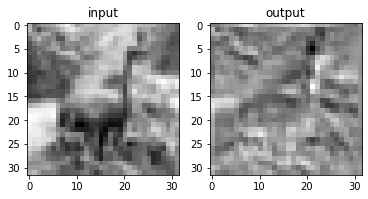

In [34]:
def show_results(img_batch, output_batch, index=0, channel=0):
  ax1 = plt.subplot(1, 2, 1)  
  img = img_batch[index] 
  plt.imshow(img.mean(0), cmap='gray')  
  plt.title('input')   
  plt.subplot(1, 2, 2) #, sharex=ax1, sharey=ax1) 
  plt.title('output')   
  out = output_batch[index, channel]
  plt.imshow(out.detach(), cmap='gray')
  plt.show()

show_results(img_t, output)

Currently the filter parameters are random.

In [35]:
print(conv)
print(conv.weight.shape) # nfeatures x nchannels x kernel x kernel
print(conv.bias.shape) # nfeatures 
print(conv.weight[0,:,:,:])

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([16, 3, 3, 3])
torch.Size([16])
tensor([[[-0.1058,  0.0373, -0.1809],
         [-0.1409,  0.0590,  0.1684],
         [ 0.1271,  0.1002,  0.0951]],

        [[-0.1837,  0.0583, -0.0172],
         [ 0.1736, -0.0064, -0.1365],
         [-0.1089, -0.0310,  0.0804]],

        [[ 0.1745, -0.1209, -0.1577],
         [-0.0519,  0.0920,  0.1084],
         [-0.1184, -0.0044,  0.0039]]], grad_fn=<SliceBackward>)


Let's make the first filter just be an averaging operation.

tensor([[[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]],

        [[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]]], grad_fn=<SliceBackward>)


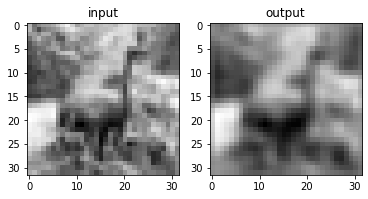

In [36]:

with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
print(conv.weight[0,:,:,:])

output = conv(img_t)
show_results(img_t, output)

Let's make the first filter be a vertical edge detector.

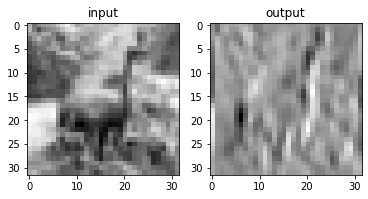

In [37]:

conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img_t)
show_results(img_t, output)

# Max-pooling

We can reduce the size of the internal feature maps by using max-pooling.

torch.Size([1, 3, 16, 16])


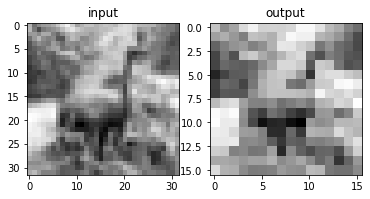

In [38]:
pool = nn.MaxPool2d(2)
output = pool(img_t)
print(output.shape)

show_results(img_t, output)

# Making our first CNN

In [86]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, nclasses, img, nchans1=16, nhidden=32):
        super().__init__()
        nchannels, nrows, ncols = img.shape
        self.nchans1 = nchans1
        self.nchans2 = nchans1//2
        self.nhidden = nhidden
        self.nclasses = nclasses
        self.conv1 = nn.Conv2d(nchannels, self.nchans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(nchans1, self.nchans2, kernel_size=3, padding=1)
        # size of input to fc1 will be  8 * nrows/4 * ncols/4, 
        # We divide by 4 since we apply 2 maxpooling layers with size 2
        # For a 32x32 image, this becomes 8x8 times 8 channnels.
        self.nflat = nrows//4 * ncols//4
        self.fc1 = nn.Linear(self.nchans2 * self.nflat, self.nhidden)
        self.fc2 = nn.Linear(self.nhidden, self.nclasses)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.nchans2 * self.nflat)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

set_seed(0)
img_batch = img_t.to(device=device)
model = Net(nclasses, img_batch[0]).to(device=device)
out_batch = model(img_batch)
print(out_batch.shape)
print(out_batch)


torch.Size([1, 10])
tensor([[ 0.1466, -0.1393,  0.1252,  0.1701, -0.0367,  0.2073, -0.0655, -0.2038,
          0.2444,  0.0490]], device='cuda:0', grad_fn=<AddmmBackward>)


# Training loop

In [90]:
import datetime  

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, 
                  l2_regularizer=0, print_every=5):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels) 

            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_regularizer * l2_norm

            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step() 
            loss_train += loss.item() 

        if epoch == 1 or epoch % print_every == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  

In [42]:

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  

model = Net(nclasses, img_batch[0]).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss() 

training_loop(  
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-03-28 21:55:45.454476 Epoch 1, Training loss 0.5770701002922787
2021-03-28 21:55:49.234000 Epoch 10, Training loss 0.3304970498867096
2021-03-28 21:55:53.406244 Epoch 20, Training loss 0.29530569654741107
2021-03-28 21:55:57.584638 Epoch 30, Training loss 0.2718532092062531
2021-03-28 21:56:01.780303 Epoch 40, Training loss 0.2536234989003011
2021-03-28 21:56:05.981223 Epoch 50, Training loss 0.23627873552832634


# Validation accuracy

In [43]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def accuracy(model, loader):
  correct = 0
  total = 0
  with torch.no_grad(): 
      for imgs, labels in loader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1) 
          total += labels.shape[0]  # batch size
          correct += int((predicted == labels).sum())  
  accuracy =  correct / total
  return accuracy


train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
print([train_acc, val_acc])

[0.9033, 0.8865]


In [44]:
# Apply the model to a minibatch
set_seed(0)
dataiter = iter(train_loader)
img_batch, label_batch = dataiter.next()
print(img_batch.shape)
img_batch = img_batch.to(device=device)
outputs = model(img_batch)
_, predicted = torch.max(outputs, dim=1) 


torch.Size([64, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


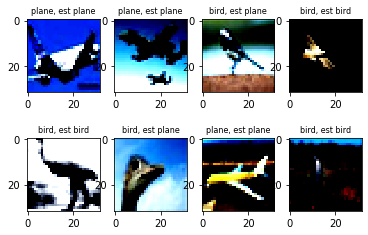

In [45]:
def imshow(img, ax):
  #img = img / 2 + 0.5     # unnormalize from -1..1 to 0..1
  npimg = img.cpu().numpy()
  ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def plot_results(images, labels, pred_labels, nrows, ncols):
  fig, axs = plt.subplots(nrows, ncols) 
  k = 0
  for i in range(nrows):
    for j in range(ncols):
      ax = axs[i,j]
      imshow(images[k], ax)
      ttl = f'{class_names[labels[k]]}, est {class_names[pred_labels[k]]}'
      ax.set_title(ttl, fontsize=8)
      k += 1

plot_results(img_batch, label_batch, predicted, 2,4)

# Save/load model

In [46]:
out = model(img_batch)
fname = os.path.join(data_path, 'birds_vs_airplanes.pt')
torch.save(model.state_dict(), fname)




In [47]:

loaded_model = Net(nclasses, img_batch[0]).to(device=device)
loaded_model.load_state_dict(torch.load(fname, map_location=device))
out2 = loaded_model(img_batch)
torch.testing.assert_allclose(out, out2)

# Dropout

We can use dropout as a form of regularization. Let's see how it works for a single convolutional layer. We pass in a single image of size 1x3x32x32 and get back a tensor of size 1x10x16x16, where 10 is the number of filters we choose, and size 16 arises because we use maxpool of 2.

torch.Size([1, 3, 32, 32])
torch.Size([1, 10, 16, 16])
<class 'torch.Tensor'>


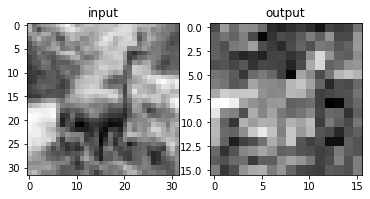

In [72]:


class NetDropout(nn.Module):
    def __init__(self, nclasses, img, nchans1=10, dropout_prob=0.4):
        super().__init__()
        nchannels, nrows, ncols = img.shape
        self.conv1 = nn.Conv2d(nchannels, nchans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(dropout_prob)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        return out

set_seed(0)
print(img_t.shape)
img_batch = img_t.to(device=device) # single image
model = NetDropout(nclasses, img_batch[0]).to(device=device)
output = model(img_batch).cpu()
print(output.shape)
print(type(output))
show_results(img_t, output)

In training model, the model is stochastic.

In [73]:
model.train()
set_seed(0)
out_batch1 = model(img_batch).detach().cpu().numpy()
out_batch2 = model(img_batch).detach().cpu().numpy()
np.allclose(out_batch1, out_batch2)

False

In testing model, the model is deterministic, since dropout is turned off.
This is controlled by the fact that the dropout layer inherits state from the parent nn.Module.

In [74]:
model.eval()
set_seed(0)
out_batch1 = model(img_batch).detach().cpu().numpy()
out_batch2 = model(img_batch).detach().cpu().numpy()
np.allclose(out_batch1, out_batch2)


True

# MNIST

We've written the model definition to work with images with any number of input channels, including just 1 (i.e., gray-scale images). It can also handle any number of output classes. Let's check that it works on 10-class gray-scale MNIST.



In [75]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from torchvision import datasets, transforms
data_path = 'data'
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST(data_path, train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST(data_path, train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1)
val_loader = torch.utils.data.DataLoader(dataset2)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [87]:
set_seed(0)

# Apply the (randomly initialized) model to a minibatch of size 1
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1)
dataiter = iter(train_loader)
img_batch, label_batch = dataiter.next()
img_batch = img_batch.to(device=device)
print(img_batch.shape)

nclasses = 10
model = Net(nclasses, img_batch[0]).to(device=device)
outputs = model(img_batch)
print(outputs.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


In [88]:
image_size = img_batch[0].shape
nchannels, nrows, ncols = image_size
print([nchannels, nrows, ncols])

[1, 28, 28]


In [91]:
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64,
                                           shuffle=True)  

model = Net(nclasses, img_batch[0], nhidden=20).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss() 

training_loop(  
    n_epochs = 20,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    print_every=1
)

2021-03-28 23:12:32.413452 Epoch 1, Training loss 1.348366360865168
2021-03-28 23:12:47.300725 Epoch 2, Training loss 0.5616921444437397
2021-03-28 23:13:02.106452 Epoch 3, Training loss 0.39617641281280946
2021-03-28 23:13:16.896062 Epoch 4, Training loss 0.32059357216808076
2021-03-28 23:13:31.614771 Epoch 5, Training loss 0.26856143299990626
2021-03-28 23:13:46.377483 Epoch 6, Training loss 0.22952063539738593
2021-03-28 23:14:01.252976 Epoch 7, Training loss 0.20017906803407395
2021-03-28 23:14:16.069047 Epoch 8, Training loss 0.1777344694666898
2021-03-28 23:14:30.700300 Epoch 9, Training loss 0.15989948194751988
2021-03-28 23:14:45.437307 Epoch 10, Training loss 0.14568282193990786
2021-03-28 23:15:00.200467 Epoch 11, Training loss 0.13381109085640927
2021-03-28 23:15:15.010119 Epoch 12, Training loss 0.12376804805315061
2021-03-28 23:15:29.809214 Epoch 13, Training loss 0.11577249571943143
2021-03-28 23:15:44.552620 Epoch 14, Training loss 0.10888972268032748
2021-03-28 23:15:59

In [92]:
val_loader = torch.utils.data.DataLoader(dataset2, batch_size=64,
                                           shuffle=True) 

train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
print([train_acc, val_acc])

[0.9783333333333334, 0.9784]
